<a href="https://colab.research.google.com/github/EliasSf73/test_/blob/master/VAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Assume CelebA images are preprocessed to 64x64 pixels
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)  # 32x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 16x16
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 8x8
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 4x4
        self.flatten = nn.Flatten()  # Flatten the convolutional layer output
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)  # Fully connected layer for mean
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  # Fully connected layer
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.conv_trans1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans3 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans4 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 4, 4)  # Reshape z to the initial size before the convolutional layers
        z = F.relu(self.conv_trans1(z))
        z = F.relu(self.conv_trans2(z))
        z = F.relu(self.conv_trans3(z))
        z = torch.sigmoid(self.conv_trans4(z))  # Output layer with sigmoid activation
        return z
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super(VAE,self).__init__()
        self.encoder=Encoder(latent_dim)
        self.decoder=Decoder(latent_dim)
    def reparametrize(self,mu,logvar):
        """
        Applies the reparameterization trick: z = mu + sigma * epsilon,
        where epsilon is sampled from a standard normal distribution.
        """
        std = torch.exp(0.5 * logvar)  # sigma = exp(0.5 * log_var), for numerical stability


        epsilon = torch.randn_like(std)  # Sample epsilon from a standard normal distribution
        z = mu + std * epsilon  # Reparameterize to get z
        return z
    def forward(self, x):
        """
        Defines the forward pass of the VAE.
        """
        mu, log_var = self.encoder(x)  # Encode input to get mu and log_var
        z = self.reparametrize(mu, log_var)  # Reparameterize to get latent vector z
        return self.decoder(z), mu, log_var


# **Train**

Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 718.808167
Train Epoch: 1 [6400/50000 (13%)]	Loss: 328.037354
Train Epoch: 1 [12800/50000 (26%)]	Loss: 210.992325
Train Epoch: 1 [19200/50000 (38%)]	Loss: 202.624405
Train Epoch: 1 [25600/50000 (51%)]	Loss: 199.323486
Train Epoch: 1 [32000/50000 (64%)]	Loss: 166.979568
Train Epoch: 1 [38400/50000 (77%)]	Loss: 135.708496
Train Epoch: 1 [44800/50000 (90%)]	Loss: 151.080688
====> Epoch: 1 Average loss: 233.5657
Train Epoch: 2 [0/50000 (0%)]	Loss: 141.395203
Train Epoch: 2 [6400/50000 (13%)]	Loss: 158.023712
Train Epoch: 2 [12800/50000 (26%)]	Loss: 133.848541
Train Epoch: 2 [19200/50000 (38%)]	Loss: 122.446747
Train Epoch: 2 [25600/50000 (51%)]	Loss: 118.632301
Train Epoch: 2 [32000/50000 (64%)]	Loss: 82.527832
Train Epoch: 2 [38400/50000 (77%)]	Loss: 101.401642
Train Epoch: 2 [44800/50000 (90%)]	Loss: 97.202179
====> Epoch: 2 Average loss: 116.2381
Train Epoch: 3 [0/50000 (0%)]	Loss: 108.912094
Train Epoch: 3 [6400/

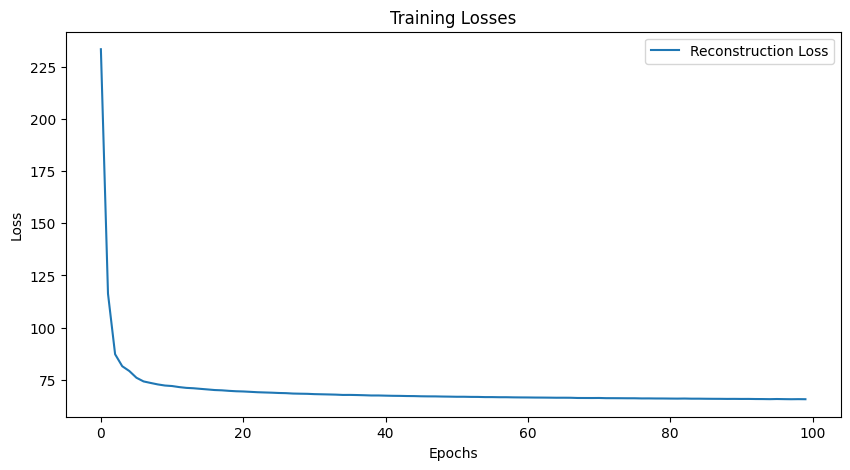

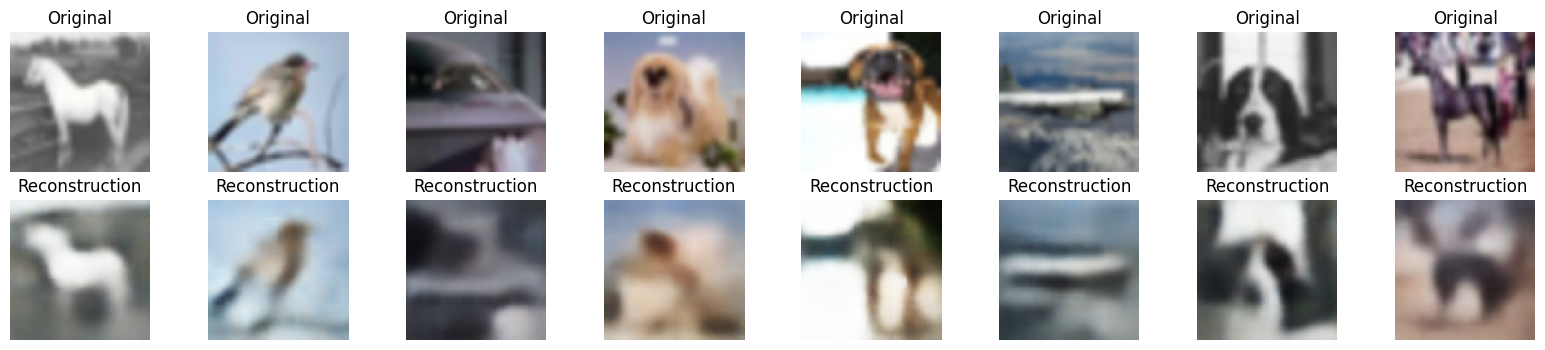

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
# from models import VAE
from sklearn.model_selection import train_test_split






# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# the hyperparameters
batch_size = 64
epochs = 100
latent_dim = 64
learning_rate = 1e-3
lambda_ = 1

# Download the CelebA dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])
cifar_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the CelebA dataset
train_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)


# Initialize VAE model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# List to track Loss
recon_losses = []
kl_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(data)
        recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * lambda_ / batch_size)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_recon_loss = train_loss / len(train_loader.dataset)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(kl_loss.item() / len(train_loader.dataset))
    print(f'====> Epoch: {epoch} Average loss: {avg_recon_loss:.4f}')

# Plotting the losses after training
def visualize_training_loss():
    plt.figure(figsize=(10,5))
    plt.title("Training Losses")
    plt.plot(recon_losses, label="Reconstruction Loss")
    # plt.plot(kl_losses, label="KL Divergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(train_loader))
        data = data.to(device)
        reconstruction, _, _ = model(data)
        data = data.cpu()
        reconstruction = reconstruction.cpu()

        # Display original and reconstructed images
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
        for i in range(num_images):
            axs[0, i].imshow(np.transpose(data[i].numpy(), (1, 2, 0)))
            axs[0, i].set_title('Original')
            axs[1, i].imshow(np.transpose(reconstruction[i].numpy(), (1, 2, 0)))
            axs[1, i].set_title('Reconstruction')
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

for epoch in range(1, epochs + 1):
    train(epoch)

torch.save(model.state_dict(), 'vae_model.pth')


visualize_training_loss()
visualize_reconstructions()